In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

In [357]:
# Simple matrices trail

# C = np.array([[-1, 1, 1, 0, 0, 8], [1, 0, -6, 0, 4, 0]])
# d = np.array([[-7], [5]])
# epsilon = 0.2
# r_init = np.array([[0], [0]])
# omg_init = np.array([[0], [0], [0], [0], [0], [0]])
# y_init = np.array([[0], [0]])
# mu = 1
# tau = 0.0015

In [358]:
def soft_thresholding(x, threshold):
    '''
    Parameters
    ----------
    x : TYPE
        np.array.
    threshold : TYPE
        float.

    Returns
    -------
    TYPE
        np.array.

    '''
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def projection_operator(x, epsilon):
    '''
    Parameters
    ----------
    x : TYPE
        np.array.
    epsilon : TYPE
        float.

    Returns
    -------
    TYPE
        np.array.

    '''
    if LA.norm(x, 2) <= epsilon:
        return x
    else:
        return epsilon * x / LA.norm(x, 2)

def r_update(omega, y):
    '''
    Parameters
    ----------
    r : TYPE
        DESCRIPTION.
    omega : TYPE
        DESCRIPTION.
    y : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.
    '''

    temp_r = np.matmul(C, omega) + d - y / mu

    return projection_operator(temp_r, epsilon)

def omega_update(r, omega, y):
    '''
    Parameters
    ----------
    r : TYPE
        DESCRIPTION.
    omega : TYPE
        DESCRIPTION.
    y : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.
    '''
    grad = np.matmul(C.T, np.matmul(C, omega) + d - r - y / mu)
    temp_omg = omega - tau * grad

    return soft_thresholding(temp_omg, tau / mu)

def y_update(r, omega, y):
    '''
    Parameters
    ----------
    r : TYPE
        DESCRIPTION.
    omega : TYPE
        DESCRIPTION.
    y : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''
    y_temp = np.matmul(C, omega) + d - r
    gap = LA.norm(y_temp, 2)

    return gap, y - mu * y_temp

def iteration(criteria, max_time, plotting = True):
    '''
    :param criteria: Error permitted for dual gap
    :param max_time: Maximal numbers of iterations permitted
    :return: Final results of three variables
    '''
    r = r_init
    omega = omg_init
    y = y_init
    it = 0
    gap = 1e+6
    it_list = []
    ob1_list = []
    ob2_list = []

    # Check the convergence theorem met or not
    if 1 / tau < np.max(LA.eigvals(np.matmul(C.T, C))) :
        raise ValueError("Error: Convergence Theorem is not met!!!!!!! Tau should be less than Max-Eigenvalue")

    # Start iterating
    while (it < max_time) & (gap > criteria):

        r = r_update(omega, y)
        omega = omega_update(r, omega, y)
        gap, y = y_update(r, omega, y)

        it += 1

        print(f"Dual gap at {it} iteration is {gap}")
        if plotting:
            obj1 = LA.norm(np.matmul(C, omega) + d ,2)
            obj2 = LA.norm(omega, 1)
            it_list.append(it)
            ob1_list.append(obj1)
            ob2_list.append(obj2)

    print(f"{it} iterations in total to convergent under criteria {criteria}")
    if plotting:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 7))
        ax1.plot(it_list, ob1_list)
        ax2.plot(it_list, ob2_list)
        ax1.set_title('L2 objective value')
        ax2.set_title('L1 Regularization objective value')

    return r, omega, y

In [359]:
# Simple 2-dimensional finite Random-Walk

# Set a random seed for reproducibility
np.random.seed(42)

# Generate 5 random numbers
random_states = np.random.choice([0, 1, 2], size = (5, 2))

# Simulate for next transition
state_len = 3
upper = 2
lower = 0

def transition_rule(state, dim = 2):

    transition = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
    state_list = []

    for i in range(dim):
        if ((state[i] != 0) & (state[i] != 2)).all():
            state_list.append(True)
        else:
            state_list.append(False)

    if all(state_list):
        random_index = np.random.randint(0, len(transition))
        state += transition[random_index]
    else:
        random_index = np.random.randint(0, len(transition))
        state_m = state + transition[random_index]
        state = np.clip(state_m, 0, 2)

    return state

def step(states):

    new_states = []
    for i, element in enumerate(states):

        next_position = transition_rule(element)
        new_states.append(next_position)

    return np.array(new_states)

new_states = step(random_states)

# Construct Polynomial feature function
def poly_feature(state):

    x = []
    s1 = state[0]
    s2 = state[1]
    for i in range(state_len):
        for j in range(state_len):
            x.append(s1 ** i * s2 ** j)

    return np.array(x)

# Immediate reward
def reward_rule(cur_state, next_state):

    if next_state[0] - cur_state[0] == 1:
        return 1
    elif next_state[1] - cur_state[1] == 1:
        return 2
    else:
        return -1

def reward_gene(states, states_next):

    R = []
    for i in range(states.shape[0]):
        R.append(reward_rule(states[i], states_next[i]))

    return np.array(R)

R = reward_gene(random_states, new_states)

# Construct matrices (pseudo-inverse matrix will be applied)
def projection(state_vec, phi_output = True):

    phi = []
    for item in state_vec:
        phi.append(poly_feature(item))
    phi_array = np.array(phi)

    if phi_output:
        return phi_array, np.dot(phi_array, LA.pinv(np.dot(phi_array.T, phi_array))).dot(phi_array.T)
    else:
        return np.dot(phi_array, LA.pinv(np.dot(phi_array.T, phi_array))).dot(phi_array.T)

def matrix_const(pi, R, phi, phi_next, gamma):

    C = gamma * np.matmul(pi, phi_next) - phi
    d= np.matmul(pi, R)
    return C, d.reshape(d.size, 1)

def var_init(C_tilde, d_tilde):

    r_init = np.zeros_like(d_tilde)
    omg_init = np.zeros((C_tilde.shape[1], 1))
    y_init = np.zeros_like(d_tilde)

    return r_init, omg_init, y_init

# Matrices
phi, pi = projection(random_states)
phi_pr = projection(new_states)[0]

C, d = matrix_const(pi, R, phi, phi_pr, 0.8)
r_init, omg_init, y_init = var_init(C, d)

In [ ]:
# Hyper-parameters

epsilon = 0.2
mu = 1
tau = 0.0015

Dual gap at 1 iteration is 1.7516857725219788
Dual gap at 2 iteration is 1.6567514631449982
Dual gap at 3 iteration is 1.63576011790008
Dual gap at 4 iteration is 1.6175198881689765
Dual gap at 5 iteration is 1.5998006295328653
Dual gap at 6 iteration is 1.5805797213738966
Dual gap at 7 iteration is 1.558902597466376
Dual gap at 8 iteration is 1.535824483260456
Dual gap at 9 iteration is 1.51204401996869
Dual gap at 10 iteration is 1.4883925970241232
Dual gap at 11 iteration is 1.4656968208887655
Dual gap at 12 iteration is 1.444700621477704
Dual gap at 13 iteration is 1.426073470759692
Dual gap at 14 iteration is 1.4103586223149736
Dual gap at 15 iteration is 1.3979361165784399
Dual gap at 16 iteration is 1.3889981807033858
Dual gap at 17 iteration is 1.383537388499144
Dual gap at 18 iteration is 1.3813495780828147
Dual gap at 19 iteration is 1.3820513480834868
Dual gap at 20 iteration is 1.385109788577116
Dual gap at 21 iteration is 1.3898805299794008
Dual gap at 22 iteration is 1.39

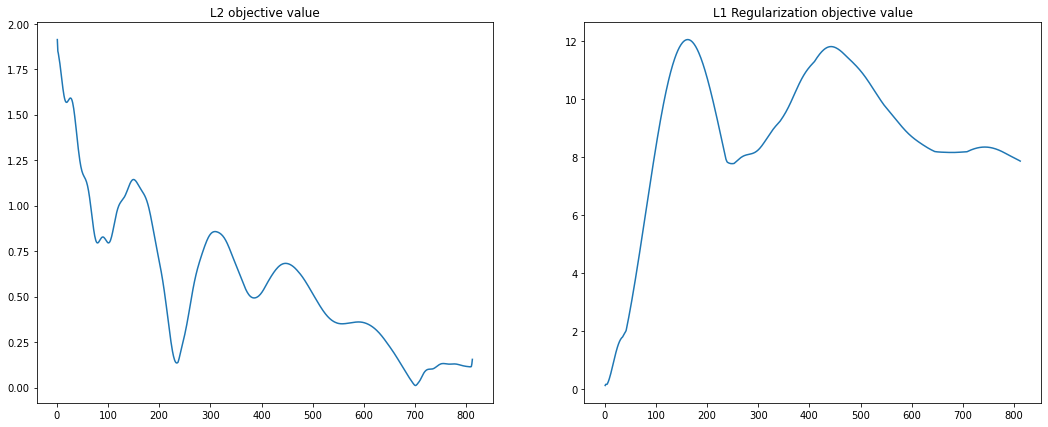

In [360]:
r_result, omega_result, y_result = iteration(0.01, 1500)